# Imports

In [7]:
import os
import gdown
import pandas as pd
import zipfile
from PIL import Image
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import TensorDataset,Dataset, DataLoader
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Downloading Dataset

In [8]:
file_ids = {
    "labels.csv": "1JY6RO6sFtUgrenkEGSkYv9B4alMkTgs9",
    "positionImageDataset.zip": "1WBEnwqc7ABEI5ujkm56s8LlOO9B4Qn8d"
}

download_paths = {
    "labels.csv": "labels.csv",
    "positionImageDataset.zip": "positionImageDataset.zip"
}

# Download files
for file_name, file_id in file_ids.items():
    url = f"https://drive.google.com/uc?id={file_id}"
    output_path = download_paths[file_name]
    print(f"Downloading {file_name}...")
    gdown.download(url, output_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1JY6RO6sFtUgrenkEGSkYv9B4alMkTgs9
To: /kaggle/working/labels.csv
100%|██████████| 785k/785k [00:00<00:00, 101MB/s]


Downloading...
From (original): https://drive.google.com/uc?id=1WBEnwqc7ABEI5ujkm56s8LlOO9B4Qn8d
From (redirected): https://drive.google.com/uc?id=1WBEnwqc7ABEI5ujkm56s8LlOO9B4Qn8d&confirm=t&uuid=f33b6f06-0116-47ae-bcef-825195768ea9
To: /kaggle/working/positionImageDataset.zip
100%|██████████| 652M/652M [00:03<00:00, 217MB/s] 


In [58]:
# Extract ZIP
zip_path = download_paths["positionImageDataset.zip"]
extracted_folder = "positionImageDataset"
if os.path.exists(zip_path):
    print("Extracting positionImageDataset.zip...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)
    print(f"Extracted to folder: {extracted_folder}")

#  Load labels.csv
csv_path = download_paths["labels.csv"]
if os.path.exists(csv_path):
    print("Loading labels.csv...")
    labels = pd.read_csv(csv_path)
else:
    raise FileNotFoundError(f"CSV file {csv_path} not found!")

Extracting positionImageDataset.zip...
Extracted to folder: positionImageDataset
Loading labels.csv...


# Analysing Dataset

In [10]:
labels.isna().sum()    # Checking Null Values

PositionImage_FileName                            0
Room Ligiting                                     0
Both hands on table?                              0
Can able to see student along with full table?    0
Computer Screen Visible?                          1
Final Decision for uploaded Image                 0
dtype: int64

In [59]:
# Process labels.csv
df = labels.copy()

# Define mappings for categorical labels
label_mappings = {
    'Room Ligiting': {'Visible': 1, 'Dark': 0},
    'Both hands on table?': {'Yes': 1, 'No': 0},
    'Can able to see student along with full table?': {'Yes': 1, 'No': 0},
    'Computer Screen Visible?': {'Yes': 1, 'No': 0},
    'Final Decision for uploaded Image': {'Approved': 1, 'Rejected': 0}
}

# Apply mappings to convert categorical labels to numeric
for column, mapping in label_mappings.items():
    df[column] = df[column].map(mapping)

# Calculate counts and percentages
total_images = len(df)
results = {
    "Label": [],
    "Count (1s)": [],
    "Percentage (1s) (%)": [],
    "Count (0s)": [],
    "Percentage (0s) (%)": []
}

for column in df.columns[1:]:  # Exclude 'PositionImage_FileName'
    count_1s = df[column].sum()  # Count of 1s
    percentage_1s = (count_1s / total_images) * 100
    count_0s = total_images - count_1s  # Count of 0s
    percentage_0s = (count_0s / total_images) * 100

    results["Label"].append(column)
    results["Count (1s)"].append(count_1s)
    results["Percentage (1s) (%)"].append(round(percentage_1s, 2))
    results["Count (0s)"].append(count_0s)
    results["Percentage (0s) (%)"].append(round(percentage_0s, 2))

results_df = pd.DataFrame(results)
# print("Processed Labels Summary:")
# print(results_df)

## Total Dataset Distribution

In [60]:
results_df

,Label,Count (1s),Percentage (1s) (%),Count (0s),Percentage (0s) (%)
0,Room Ligiting,10238.0,91.48,954.0,8.52
1,Both hands on table?,8865.0,79.21,2327.0,20.79
2,Can able to see student along with full table?,9635.0,86.09,1557.0,13.91
3,Computer Screen Visible?,9478.0,84.69,1714.0,15.31
4,Final Decision for uploaded Image,7989.0,71.38,3203.0,28.62


# Splitting and Loading the Dataset

In [61]:
# Define PyTorch Dataset
class PositionalImageDataset(Dataset):
    def __init__(self, image_dir, labels_csv, transform=None):
        self.image_dir = image_dir
        self.labels = pd.read_csv(labels_csv).fillna('Yes')
        self.transform = transform
        self.label_mappings = {
            'Room Ligiting': {'Visible': 1, 'Dark': 0},
            'Both hands on table?': {'Yes': 1, 'No': 0},
            'Can able to see student along with full table?': {'Yes': 1, 'No': 0},
            'Computer Screen Visible?': {'Yes': 1, 'No': 0},
            'Final Decision for uploaded Image': {'Approved': 1, 'Rejected': 0}
        }

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        try:
            img_name = self.labels.iloc[idx, 0]
            img_path = os.path.join(self.image_dir, img_name)

            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)

            row = self.labels.iloc[idx, 1:]
            encoded_labels = []
            for column_name, mapping in self.label_mappings.items():
                value = row[column_name]
                if value not in mapping:
                    raise ValueError(f"Unexpected value '{value}' in column '{column_name}'.")
                encoded_labels.append(mapping[value])
            encoded_labels = torch.tensor(encoded_labels, dtype=torch.float32)

            attribute_labels = encoded_labels[:-1]
            final_label = encoded_labels[-1]
            return image, attribute_labels, final_label

        except Exception as e:
            print(f"Error at index {idx}: {e}")
            raise



# Initialize Dataset and DataLoader
image_dir = os.path.join(extracted_folder, "positionImageDataset")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = PositionalImageDataset(image_dir=image_dir, labels_csv=csv_path, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Debugging: Print shapes of one batch
for images, attribute_labels, final_labels in train_loader:
    print("Image Batch Shape:", images.shape)
    print("Attribute Labels Shape:", attribute_labels.shape)
    print("Final Labels Shape:", final_labels.shape)
    break

Image Batch Shape: torch.Size([32, 3, 240, 240])
Attribute Labels Shape: torch.Size([32, 4])
Final Labels Shape: torch.Size([32])


## Training and validation Dataset Distributions

In [77]:
# Function to calculate label statistics
def calculate_label_stats(dataset, label_columns, total_images):
    results = {
        "Label": [],
        "Count (1s)": [],
        "Percentage (1s) (%)": [],
        "Count (0s)": [],
        "Percentage (0s) (%)": []
    }
    
    # Initialize counters for each label column
    label_counts = {label: {"1s": 0, "0s": 0} for label in label_columns}

    # Iterate through the dataset
    for _, attribute_labels, final_labels in DataLoader(dataset, batch_size=32):
        for i, label in enumerate(label_columns[:-1]):  # For attribute labels
            label_values = attribute_labels[:, i]
            label_counts[label]["1s"] += label_values.sum().item()
            label_counts[label]["0s"] += (1 - label_values).sum().item()

        # For the final decision label
        label = label_columns[-1]
        label_counts[label]["1s"] += final_labels.sum().item()
        label_counts[label]["0s"] += (1 - final_labels).sum().item()

    # Calculate percentages and organize results
    for label, counts in label_counts.items():
        count_1s = counts["1s"]
        count_0s = counts["0s"]
        percentage_1s = (count_1s / total_images) * 100
        percentage_0s = (count_0s / total_images) * 100

        results["Label"].append(label)
        results["Count (1s)"].append(int(count_1s))
        results["Percentage (1s) (%)"].append(round(percentage_1s, 2))
        results["Count (0s)"].append(int(count_0s))
        results["Percentage (0s) (%)"].append(round(percentage_0s, 2))

    return pd.DataFrame(results)

# Get label columns including the final decision
label_columns = list(dataset.label_mappings.keys())  # Include all labels
train_total_images = len(train_dataset)
val_total_images = len(val_dataset)

# Calculate results for train and validation datasets
train_results_df = calculate_label_stats(train_dataset, label_columns, train_total_images)
val_results_df = calculate_label_stats(val_dataset, label_columns, val_total_images)

# Display results
print("Training Set Label Statistics:")
print(train_results_df)

print("\nValidation Set Label Statistics:")
print(val_results_df)


Training Set Label Statistics:
                                            Label  Count (1s)  \
0                                   Room Ligiting        8189   
1                            Both hands on table?        7112   
2  Can able to see student along with full table?        7715   
3                        Computer Screen Visible?        7577   
4               Final Decision for uploaded Image        6407   

   Percentage (1s) (%)  Count (0s)  Percentage (0s) (%)  
0                91.47         764                 8.53  
1                79.44        1841                20.56  
2                86.17        1238                13.83  
3                84.63        1376                15.37  
4                71.56        2546                28.44  

Validation Set Label Statistics:
                                            Label  Count (1s)  \
0                                   Room Ligiting        2049   
1                            Both hands on table?        1753   
2

In [78]:
train_results_df

,Label,Count (1s),Percentage (1s) (%),Count (0s),Percentage (0s) (%)
0,Room Ligiting,8189,91.47,764,8.53
1,Both hands on table?,7112,79.44,1841,20.56
2,Can able to see student along with full table?,7715,86.17,1238,13.83
3,Computer Screen Visible?,7577,84.63,1376,15.37
4,Final Decision for uploaded Image,6407,71.56,2546,28.44


In [79]:
val_results_df

,Label,Count (1s),Percentage (1s) (%),Count (0s),Percentage (0s) (%)
0,Room Ligiting,2049,91.51,190,8.49
1,Both hands on table?,1753,78.29,486,21.71
2,Can able to see student along with full table?,1920,85.75,319,14.25
3,Computer Screen Visible?,1902,84.95,337,15.05
4,Final Decision for uploaded Image,1582,70.66,657,29.34


# Metrics

In [62]:
def compute_metrics(y_true, y_pred):
    """
    Computes accuracy, recall, precision, and F1 score.
    Args:
        y_true (torch.Tensor): True labels.
        y_pred (torch.Tensor): Predicted probabilities or logits.
    Returns:
        dict: Dictionary containing the metrics.
    """
    # Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).int()
    
    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1,
    }


#  Model Training

In [63]:
class CustomCNN(nn.Module):
    def __init__(self, output_features):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (32, 240, 240)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 120, 120)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 120, 120)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 60, 60)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (128, 60, 60)
            # nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1),  # (128, 60, 60)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (128, 30, 30)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 30 * 30, output_features),  # Match flattened size
            # nn.Linear(128 * 60 * 60, output_features), 
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        # print("After conv_layers:", x.shape)  # Check shape here
        x = self.fc(x)
        # print("After fc:", x.shape)           # Check shape here
        return x


# Base Model with Custom CNN
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.backbone = CustomCNN(output_features=128)  # Extract 128 features
        self.classifier = nn.Linear(128, 1)  # Single output for binary classification

    def forward(self, x):
        features = self.backbone(x)
        return torch.sigmoid(self.classifier(features))  # Output probability for each class

# Initialize base models with Custom CNN
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_models = [BaseModel().to(device) for _ in range(4)]

# Meta Model with Custom CNN
class MetaModel(nn.Module):
    def __init__(self):
        super(MetaModel, self).__init__()
        # Convolutional backbone for the image input
        self.image_backbone = CustomCNN(output_features=128)  # Extract 128 features
        
        # Fully connected layers to combine image features and base model outputs
        self.fc = nn.Sequential(
            nn.Linear(128 + 4, 64),  # 128 (image features) + 4 (base model outputs)
            nn.ReLU(),
            nn.Linear(64, 1)  # Output: Final decision
        )

    def forward(self, image, base_outputs):
        # Extract features from the image
        image_features = self.image_backbone(image)  # Shape: [batch_size, 128]
        
        # Concatenate image features and base model outputs
        combined = torch.cat([image_features, base_outputs], dim=1)  # Shape: [batch_size, 128 + 4]
        
        # Predict final decision
        return torch.sigmoid(self.fc(combined))  # Output probability


## Feature(Base) Model Training-validation

In [64]:
def train_and_evaluate(base_models, train_loader, val_loader, device, epochs=5, lr=0.001, patience=3):
    """
    Trains base models and evaluates metrics, including metrics before training (epoch 0).
    Supports early stopping and saves the 4 best models based on validation metrics.

    Args:
        base_models (list): List of models to train and evaluate.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        device (str): 'cuda' or 'cpu'.
        epochs (int): Number of epochs to train.
        lr (float): Learning rate for the optimizer.
        patience (int): Number of epochs to wait for improvement before early stopping.

    Returns:
        list: A list containing dictionaries with loss and metrics for each model.
    """
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    results = []  # To store results for each model

    for i, base_model in enumerate(base_models):
        optimizer = torch.optim.Adam(base_model.parameters(), lr=lr)
        model_results = {"train_loss": [], "val_loss": [], "metrics": []}  # To store epoch-wise results

        # Early stopping setup
        best_metric = float('-inf')  # Initialize the best metric
        no_improvement_epochs = 0   # Count epochs without improvement
        best_model_path = f"best_model_{i+1}.pth"  # Path to save the best model

        # Evaluate metrics for epoch 0 (before training starts)
        print(f"Base Model {i+1}: Evaluating metrics for Epoch 0 (Before Training)")
        base_model.eval()
        all_labels, all_predictions = [], []
        val_loss = 0.0
        model_results["train_loss"].append(None)  # No training loss for epoch 0
        with torch.no_grad():
            for images, attribute_labels, _ in tqdm(val_loader, desc="Validation (Epoch 0)", leave=False):
                images, attribute_labels = images.to(device), attribute_labels.to(device)
                labels = attribute_labels[:, i:i+1]
                outputs = base_model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                all_labels.append(labels.cpu())
                all_predictions.append(outputs.cpu())

        # Concatenate and compute metrics for epoch 0
        all_labels = torch.cat(all_labels)
        all_predictions = torch.cat(all_predictions)
        metrics = compute_metrics(all_labels, all_predictions)
        val_loss /= len(val_loader)
        model_results["val_loss"].append(val_loss)
        model_results["metrics"].append(metrics)
        print(f"Base Model {i+1}, Epoch 0: Val Loss: {val_loss:.4f}, Metrics: {metrics}")

        # Training and validation loop
        for epoch in range(epochs):
            # Training
            base_model.train()
            running_loss = 0.0
            train_loader_tqdm = tqdm(train_loader, desc=f"Training Model {i+1}, Epoch {epoch+1}/{epochs}", leave=False)
            for images, attribute_labels, _ in train_loader_tqdm:
                images, attribute_labels = images.to(device), attribute_labels.to(device)
                labels = attribute_labels[:, i:i+1]  # Select the i-th attribute column

                optimizer.zero_grad()
                outputs = base_model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                # Update tqdm bar with loss
                train_loader_tqdm.set_postfix(loss=loss.item())

            avg_loss = running_loss / len(train_loader)
            model_results["train_loss"].append(avg_loss)

            # Validation
            base_model.eval()
            all_labels, all_predictions = [], []
            val_loss = 0.0  # Reset validation loss for this epoch
            val_loader_tqdm = tqdm(val_loader, desc=f"Validation Model {i+1}, Epoch {epoch+1}/{epochs}", leave=False)
            with torch.no_grad():
                for images, attribute_labels, _ in val_loader_tqdm:
                    images, attribute_labels = images.to(device), attribute_labels.to(device)
                    labels = attribute_labels[:, i:i+1]
                    outputs = base_model(images)

                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    all_labels.append(labels.cpu())
                    all_predictions.append(outputs.cpu())

            # Concatenate and compute metrics
            val_loss /= len(val_loader)
            all_labels = torch.cat(all_labels)
            all_predictions = torch.cat(all_predictions)
            metrics = compute_metrics(all_labels, all_predictions)
            model_results["val_loss"].append(val_loss)
            model_results["metrics"].append(metrics)

            # Print progress
            print(f"Base Model {i+1}, Epoch {epoch+1}: Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Metrics: {metrics}")

            # Check for improvement and save the best model
            current_metric = metrics["f1"]  # Example: use F1 score as the primary metric
            if current_metric > best_metric:
                best_metric = current_metric
                no_improvement_epochs = 0
                torch.save(base_model, best_model_path)
                print(f"Base Model {i+1}, Epoch {epoch+1}: New best model saved with F1 score {best_metric:.4f}")
            else:
                no_improvement_epochs += 1
                print(f"Base Model {i+1}, Epoch {epoch+1}: No improvement for {no_improvement_epochs} epoch(s)")

            # Early stopping
            if no_improvement_epochs >= patience:
                print(f"Base Model {i+1}: Early stopping triggered at epoch {epoch+1}")
                break

        results.append(model_results)

    return results


In [65]:
def plot_all_models(results):
    """
    Plots training loss, validation loss, and metrics for all models, including epoch 0.

    Args:
        results (list): List of dictionaries containing loss, val_loss, and metrics for each model.
    """
    for i, model_results in enumerate(results):
        epochs = len(model_results["train_loss"])   # Including epoch 0
        epoch_range = range(0, epochs)  # From epoch 0 to last epoch

        # Extract losses and metrics
        losses =  model_results["train_loss"]  # No training loss for epoch 0
        val_losses = model_results["val_loss"]
        accuracies = [m["accuracy"] for m in model_results["metrics"]]
        recalls = [m["recall"] for m in model_results["metrics"]]
        precisions = [m["precision"] for m in model_results["metrics"]]
        f1_scores = [m["f1"] for m in model_results["metrics"]]

        # Create subplots
        plt.figure(figsize=(15, 5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(epoch_range, losses, label="Training Loss", color="blue", marker="o")
        plt.plot(epoch_range, val_losses, label="Validation Loss", color="orange", marker="s")
        plt.title(f"Model {i+1}: Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.legend()

        # Plot Metrics
        plt.subplot(1, 2, 2)
        plt.plot(epoch_range, accuracies, label="Accuracy", marker="o")
        plt.plot(epoch_range, recalls, label="Recall", marker="s")
        plt.plot(epoch_range, precisions, label="Precision", marker="^")
        plt.plot(epoch_range, f1_scores, label="F1 Score", marker="d")
        plt.title(f"Model {i+1}: Validation Metrics")
        plt.xlabel("Epoch")
        plt.ylabel("Score")
        plt.grid(True)
        plt.legend()

        # Display the plots
        plt.tight_layout()
        plt.show()

In [67]:
results = train_and_evaluate(
    base_models=base_models,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=10,
    lr=0.001
)


Base Model 1: Evaluating metrics for Epoch 0 (Before Training)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Base Model 1, Epoch 0: Val Loss: 0.7340, Metrics: {'accuracy': 0.08485931219294328, 'recall': 0.0, 'precision': 0.0, 'f1': 0.0}


Base Model 1, Epoch 1: Loss: 8.5276, Val Loss: 8.4865, Metrics: {'accuracy': 0.9151406878070567, 'recall': 1.0, 'precision': 0.9151406878070567, 'f1': 0.9556902985074627}
Base Model 1, Epoch 1: New best model saved with F1 score 0.9557


Base Model 1, Epoch 2: Loss: 8.5299, Val Loss: 8.4865, Metrics: {'accuracy': 0.9151406878070567, 'recall': 1.0, 'precision': 0.9151406878070567, 'f1': 0.9556902985074627}
Base Model 1, Epoch 2: No improvement for 1 epoch(s)


Base Model 1, Epoch 3: Loss: 8.5362, Val Loss: 8.4865, Metrics: {'accuracy': 0.9151406878070567, 'recall': 1.0, 'precision': 0.9151406878070567, 'f1': 0.9556902985074627}
Base Model 1, Epoch 3: No improvement for 2 epoch(s)


Base Model 1, Epoch 4: Loss: 8.5393, Val Loss: 8.4865, Metrics: {'accuracy': 0.9151406878070567, 'recall': 1.0, 'precision': 0.9151406878070567, 'f1': 0.9556902985074627}
Base Model 1, Epoch 4: No improvement for 3 epoch(s)
Base Model 1: Early stopping triggered at epoch 4
Base Model 2: Evaluating metrics for Epoch 0 (Before Training)


Base Model 2, Epoch 0: Val Loss: 0.6624, Metrics: {'accuracy': 0.7829388119696293, 'recall': 1.0, 'precision': 0.7829388119696293, 'f1': 0.8782565130260521}


Base Model 2, Epoch 1: Loss: 20.5313, Val Loss: 21.7065, Metrics: {'accuracy': 0.7829388119696293, 'recall': 1.0, 'precision': 0.7829388119696293, 'f1': 0.8782565130260521}
Base Model 2, Epoch 1: New best model saved with F1 score 0.8783


Base Model 2, Epoch 2: Loss: 20.5531, Val Loss: 21.7065, Metrics: {'accuracy': 0.7829388119696293, 'recall': 1.0, 'precision': 0.7829388119696293, 'f1': 0.8782565130260521}
Base Model 2, Epoch 2: No improvement for 1 epoch(s)


Base Model 2, Epoch 3: Loss: 20.5688, Val Loss: 21.7065, Metrics: {'accuracy': 0.7829388119696293, 'recall': 1.0, 'precision': 0.7829388119696293, 'f1': 0.8782565130260521}
Base Model 2, Epoch 3: No improvement for 2 epoch(s)


Base Model 2, Epoch 4: Loss: 20.5688, Val Loss: 21.7065, Metrics: {'accuracy': 0.7829388119696293, 'recall': 1.0, 'precision': 0.7829388119696293, 'f1': 0.8782565130260521}
Base Model 2, Epoch 4: No improvement for 3 epoch(s)
Base Model 2: Early stopping triggered at epoch 4
Base Model 3: Evaluating metrics for Epoch 0 (Before Training)


Base Model 3, Epoch 0: Val Loss: 0.6993, Metrics: {'accuracy': 0.22599374720857526, 'recall': 0.15364583333333334, 'precision': 0.7320099255583127, 'f1': 0.25398191993112357}


Base Model 3, Epoch 1: Loss: 13.7699, Val Loss: 14.2454, Metrics: {'accuracy': 0.8575256811076374, 'recall': 1.0, 'precision': 0.8575256811076374, 'f1': 0.9232988699206541}
Base Model 3, Epoch 1: New best model saved with F1 score 0.9233


Base Model 3, Epoch 2: Loss: 13.8263, Val Loss: 14.2454, Metrics: {'accuracy': 0.8575256811076374, 'recall': 1.0, 'precision': 0.8575256811076374, 'f1': 0.9232988699206541}
Base Model 3, Epoch 2: No improvement for 1 epoch(s)


Base Model 3, Epoch 3: Loss: 13.8295, Val Loss: 14.2454, Metrics: {'accuracy': 0.8575256811076374, 'recall': 1.0, 'precision': 0.8575256811076374, 'f1': 0.9232988699206541}
Base Model 3, Epoch 3: No improvement for 2 epoch(s)


Base Model 3, Epoch 4: Loss: 13.8263, Val Loss: 14.2454, Metrics: {'accuracy': 0.8575256811076374, 'recall': 1.0, 'precision': 0.8575256811076374, 'f1': 0.9232988699206541}
Base Model 3, Epoch 4: No improvement for 3 epoch(s)
Base Model 3: Early stopping triggered at epoch 4
Base Model 4: Evaluating metrics for Epoch 0 (Before Training)


Base Model 4, Epoch 0: Val Loss: 0.6934, Metrics: {'accuracy': 0.4899508709245199, 'recall': 0.5042060988433228, 'precision': 0.8281519861830743, 'f1': 0.626797385620915}


Base Model 4, Epoch 1: Loss: 0.4622, Val Loss: 0.3528, Metrics: {'accuracy': 0.880303707012059, 'recall': 0.9978969505783386, 'precision': 0.877890841813136, 'f1': 0.9340551181102363}
Base Model 4, Epoch 1: New best model saved with F1 score 0.9341


Base Model 4, Epoch 2: Loss: 0.3467, Val Loss: 0.3492, Metrics: {'accuracy': 0.884323358642251, 'recall': 0.991062039957939, 'precision': 0.8862247296661965, 'f1': 0.9357160585753288}
Base Model 4, Epoch 2: New best model saved with F1 score 0.9357


Base Model 4, Epoch 3: Loss: 0.3176, Val Loss: 0.3621, Metrics: {'accuracy': 0.8865564984368022, 'recall': 0.9873817034700315, 'precision': 0.8908918406072106, 'f1': 0.9366583541147133}
Base Model 4, Epoch 3: New best model saved with F1 score 0.9367


Base Model 4, Epoch 4: Loss: 0.2780, Val Loss: 0.3805, Metrics: {'accuracy': 0.8838767306833408, 'recall': 0.9852786540483701, 'precision': 0.8898385565052231, 'f1': 0.935129740518962}
Base Model 4, Epoch 4: No improvement for 1 epoch(s)


Base Model 4, Epoch 5: Loss: 0.2188, Val Loss: 0.4069, Metrics: {'accuracy': 0.864671728450201, 'recall': 0.9511041009463722, 'precision': 0.8959881129271917, 'f1': 0.9227237949502678}
Base Model 4, Epoch 5: No improvement for 2 epoch(s)


Base Model 4, Epoch 6: Loss: 0.1400, Val Loss: 0.5353, Metrics: {'accuracy': 0.8709245198749441, 'recall': 0.9616193480546793, 'precision': 0.8943765281173595, 'f1': 0.9267798327843932}
Base Model 4, Epoch 6: No improvement for 3 epoch(s)
Base Model 4: Early stopping triggered at epoch 6


In [55]:
# results

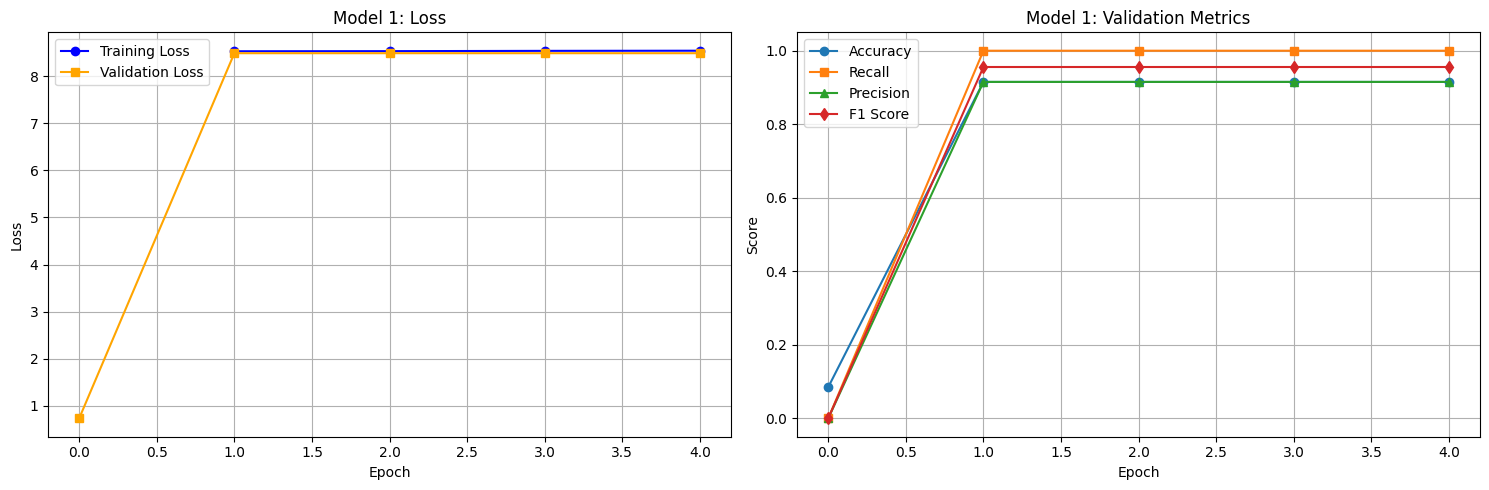

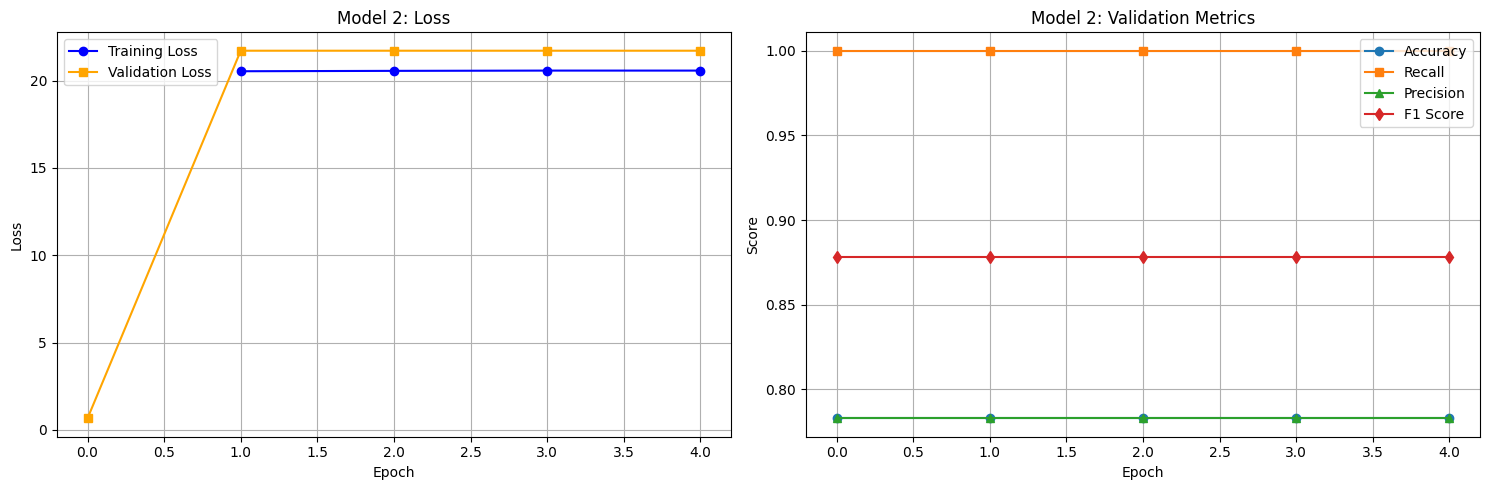

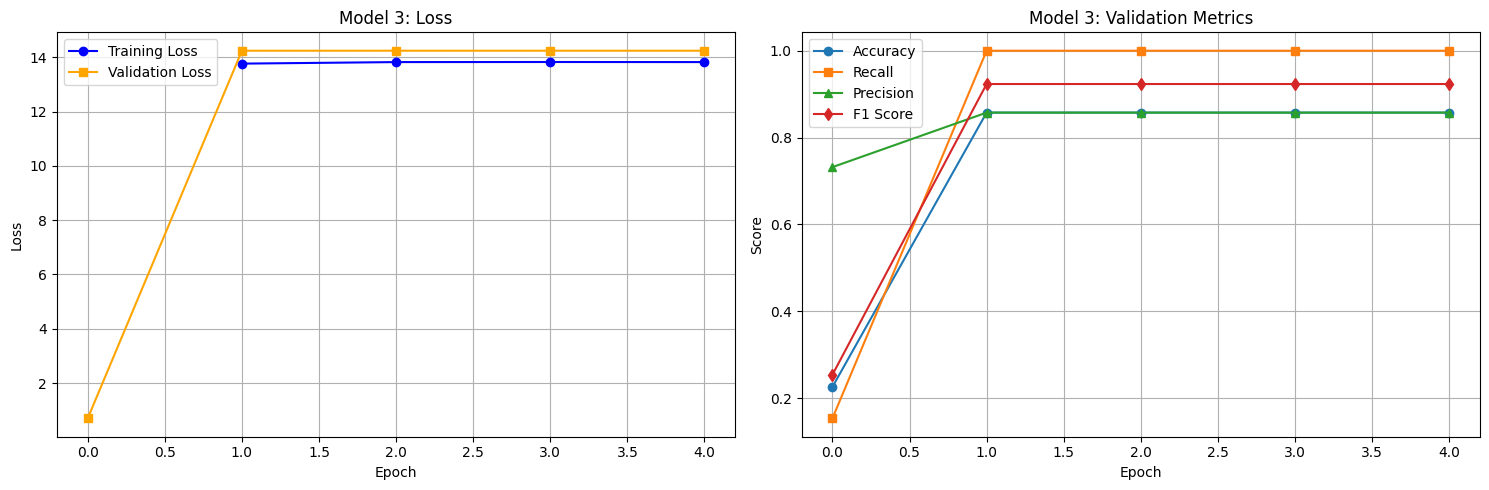

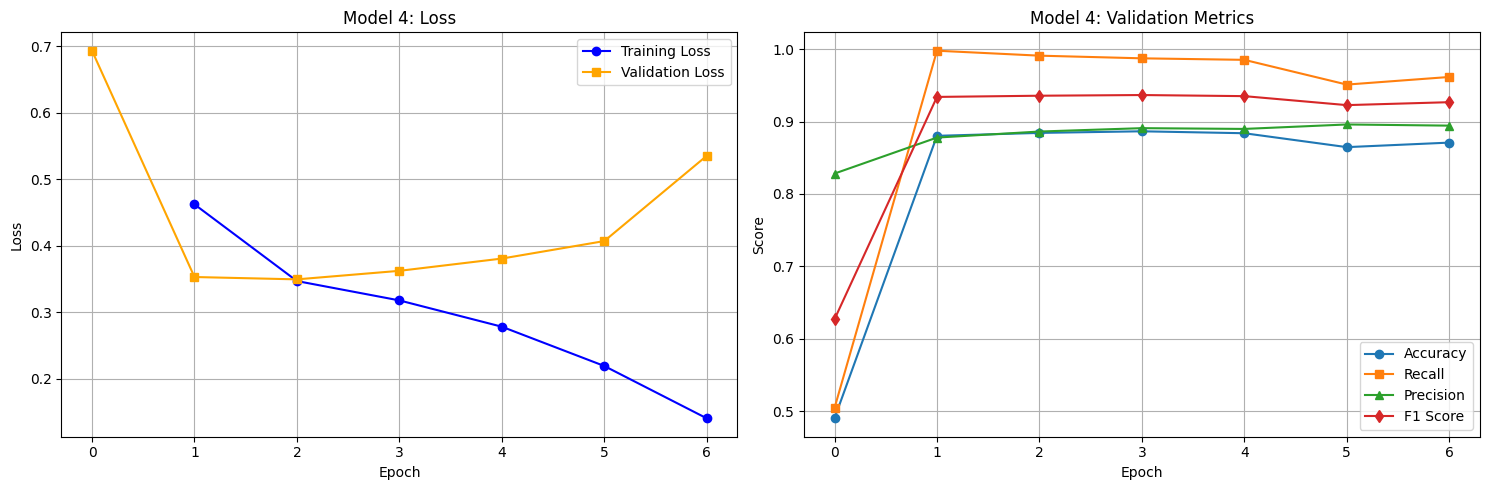

In [68]:
plot_all_models(results)


## Preparing Dataset For Meta-Model

In [80]:
def collect_base_outputs(base_models, loader, device='cuda'):
    meta_inputs = []
    meta_labels = []
    all_images = []  # Store images for later use

    for batch_idx, (images, attribute_labels, final_labels) in enumerate(loader):
        
        if((batch_idx+1)%20==0):
            print(f"Processing batch {batch_idx + 1}/{len(loader)}")
        
        # Move labels to GPU (images will be processed per model)
        final_labels = final_labels.to(device)
        all_images.append(images.cpu())  # Keep images on CPU for now
        
        # Collect outputs for all base models
        base_outputs = []
        for model_idx, model in enumerate(base_models):
            model = model.to(device)  # Ensure the model is on the device
            
            # Process images batch for this model
            with torch.no_grad():
                outputs = model(images.to(device)).detach().cpu()  # Compute and move to CPU
                base_outputs.append(outputs)
                # print(f"Base model {model_idx + 1} outputs collected.")
        
        # Concatenate outputs for all base models
        base_outputs = torch.cat(base_outputs, dim=1)  # Concatenate all base outputs
        meta_inputs.append(base_outputs)  # Store only base outputs
        meta_labels.append(final_labels.cpu())  # Move labels to CPU
        
        # # Clean up GPU memory after processing all models for the current batch
        # del images, attribute_labels, final_labels, outputs, base_outputs
        # torch.cuda.empty_cache()
    
    # Return the collected meta inputs, labels, and images
    return torch.cat(meta_inputs), torch.cat(meta_labels), torch.cat(all_images)


In [70]:

# Prepare meta-model training data
meta_inputs, meta_labels, images = collect_base_outputs(base_models, train_loader)

# Create a dataset with images, meta_inputs, and labels
meta_dataset = TensorDataset(images, meta_inputs, meta_labels)

# Use DataLoader with a smaller batch size
meta_loader = DataLoader(meta_dataset, batch_size=32, shuffle=True)


Processing batch 20/280
Processing batch 40/280
Processing batch 60/280
Processing batch 80/280
Processing batch 100/280
Processing batch 120/280
Processing batch 140/280
Processing batch 160/280
Processing batch 180/280
Processing batch 200/280
Processing batch 220/280
Processing batch 240/280
Processing batch 260/280
Processing batch 280/280


In [71]:
# Prepare meta-model training data
meta_inputs, meta_labels, images = collect_base_outputs(base_models, val_loader)

# Create a dataset with images, meta_inputs, and labels
meta_val_dataset = TensorDataset(images, meta_inputs, meta_labels)

# Use DataLoader with a smaller batch size
meta_val_loader = DataLoader(meta_dataset, batch_size=32, shuffle=True)

Processing batch 20/70
Processing batch 40/70
Processing batch 60/70


## Evaluating Simple (if-else )meta Model without any Backbone

In [81]:
def evaluate_simple_meta_model(meta_loader, meta_val_loader, device):
    """
    Evaluate a simple meta-model that predicts 1 if all base model outputs are 1, else 0.

    Args:
        meta_loader: DataLoader providing base model outputs and ground truth labels for training data.
        meta_val_loader: DataLoader providing base model outputs and ground truth labels for validation data.
        device: Device to use for computation (e.g., 'cuda' or 'cpu').

    Returns:
        results: A dictionary containing metrics for training and validation data.
    """
    def compute_predictions_and_metrics(loader, phase):
        all_labels = []
        all_predictions = []
        loader_tqdm = tqdm(loader, desc=f"Evaluating {phase} Data", leave=False)

        with torch.no_grad():
            for _, base_outputs, labels in loader_tqdm:
                # Move base_outputs and labels to the appropriate device
                base_outputs, labels = base_outputs.to(device), labels.to(device)

                # Predict 1 if all base outputs are 1, else 0
                predictions = (base_outputs.prod(dim=1) == 1).float()

                # Collect labels and predictions
                all_labels.append(labels.cpu())
                all_predictions.append(predictions.cpu())

        # Concatenate all labels and predictions
        all_labels = torch.cat(all_labels)
        all_predictions = torch.cat(all_predictions)

        # Compute metrics
        metrics = compute_metrics(all_labels, all_predictions)
        print(f"{phase} Metrics: {metrics}")

        return metrics

    results = {
        "training_metrics": compute_predictions_and_metrics(meta_loader, "Training"),
        "validation_metrics": compute_predictions_and_metrics(meta_val_loader, "Validation"),
    }

    return results


In [92]:
results = evaluate_simple_meta_model(meta_loader, meta_val_loader, device='cuda')

print("Training Metrics:", results["training_metrics"])
print("Validation Metrics:", results["validation_metrics"])


Training Metrics: {'accuracy': 0.2859376745225064, 'recall': 0.0023411893241766816, 'precision': 0.9375, 'f1': 0.004670714619336758}


Validation Metrics: {'accuracy': 0.2859376745225064, 'recall': 0.0023411893241766816, 'precision': 0.9375, 'f1': 0.004670714619336758}
Training Metrics: {'accuracy': 0.2859376745225064, 'recall': 0.0023411893241766816, 'precision': 0.9375, 'f1': 0.004670714619336758}
Validation Metrics: {'accuracy': 0.2859376745225064, 'recall': 0.0023411893241766816, 'precision': 0.9375, 'f1': 0.004670714619336758}


In [94]:
# Create DataFrame
metrics_df = pd.DataFrame({
    'Metric': results["training_metrics"].keys(),
    'Training': results["training_metrics"].values(),
    'Validation': results["validation_metrics"].values()
})

metrics_df


,Metric,Training,Validation
0,accuracy,0.285938,0.285938
1,recall,0.002341,0.002341
2,precision,0.937500,0.937500
3,f1,0.004671,0.004671


## Training & evaluating meta-model with backbone

In [89]:
def train_meta_model(meta_model, meta_loader, meta_val_loader, meta_optimizer, criterion, device, num_epochs=10):
    """
    Train the meta-model and collect metrics for plotting, including 0th epoch metrics.
    
    Args:
        meta_model: The meta-model to train.
        meta_loader: DataLoader for training data.
        meta_val_loader: DataLoader for validation data.
        meta_optimizer: Optimizer for the meta-model.
        criterion: Loss function.
        device: Device to use for training (e.g., 'cuda' or 'cpu').
        num_epochs: Number of epochs to train for.

    Returns:
        results: A dictionary containing training and validation losses and metrics for each epoch.
    """
    results = {
        "train_loss": [],
        "val_loss": [],
        "metrics": []
    }

    # 0th epoch validation
    meta_model.eval()
    all_labels = []
    all_predictions = []
    val_total_loss = 0

    print(f"Epoch 0 - Initial Validation Phase")
    val_loader_tqdm = tqdm(meta_val_loader, desc="Validation Epoch 0", leave=False)

    with torch.no_grad():
        for images, base_outputs, labels in val_loader_tqdm:
            images, base_outputs, labels = images.to(device), base_outputs.to(device), labels.to(device)
            outputs = meta_model(images, base_outputs)  # Pass both images and base_outputs
            loss = criterion(outputs.squeeze(-1), labels)
            val_total_loss += loss.item()
            all_labels.append(labels.cpu())
            all_predictions.append(outputs.cpu())

    val_avg_loss = val_total_loss / len(meta_val_loader)
    all_labels = torch.cat(all_labels)
    all_predictions = torch.cat(all_predictions)
    metrics = compute_metrics(all_labels, all_predictions)

    results["train_loss"].append(None)  # No training loss for epoch 0
    results["val_loss"].append(val_avg_loss)
    results["metrics"].append(metrics)

    print(f"Meta Model Epoch 0: Initial Validation Loss: {val_avg_loss:.4f}")
    print(f"Meta Model Epoch 0: Initial Validation Metrics: {metrics}")
    
    # Training and validation for subsequent epochs
    for epoch in range(1, num_epochs + 1):
        # Training phase
        meta_model.train()
        train_total_loss = 0

        print(f"Epoch {epoch}/{num_epochs} - Training Phase")
        train_loader_tqdm = tqdm(meta_loader, desc=f"Training Epoch {epoch}/{num_epochs}", leave=False)

        for images, base_outputs, labels in train_loader_tqdm:
            images, base_outputs, labels = images.to(device), base_outputs.to(device), labels.to(device)

            meta_optimizer.zero_grad()
            outputs = meta_model(images, base_outputs).squeeze(-1)  # Pass both images and base_outputs
            loss = criterion(outputs, labels)
            loss.backward()
            meta_optimizer.step()

            train_total_loss += loss.item()

            # Update tqdm with batch loss
            train_loader_tqdm.set_postfix(loss=loss.item())

        train_avg_loss = train_total_loss / len(meta_loader)
        results["train_loss"].append(train_avg_loss)
        print(f"Meta Model Epoch {epoch}: Average Training Loss: {train_avg_loss:.4f}")

        # Validation phase
        meta_model.eval()
        val_total_loss = 0
        all_labels = []
        all_predictions = []

        print(f"Epoch {epoch}/{num_epochs} - Validation Phase")
        val_loader_tqdm = tqdm(meta_val_loader, desc=f"Validation Epoch {epoch}/{num_epochs}", leave=False)

        with torch.no_grad():
            for images, base_outputs, labels in val_loader_tqdm:
                images, base_outputs, labels = images.to(device), base_outputs.to(device), labels.to(device)
                outputs = meta_model(images, base_outputs)  # Pass both images and base_outputs
                loss = criterion(outputs.squeeze(-1), labels)
                val_total_loss += loss.item()
                all_labels.append(labels.cpu())
                all_predictions.append(outputs.cpu())

        val_avg_loss = val_total_loss / len(meta_val_loader)
        all_labels = torch.cat(all_labels)
        all_predictions = torch.cat(all_predictions)
        metrics = compute_metrics(all_labels, all_predictions)

        results["val_loss"].append(val_avg_loss)
        results["metrics"].append(metrics)
        print(f"Meta Model Epoch {epoch}: Validation Loss: {val_avg_loss:.4f}")
        print(f"Meta Model Epoch {epoch}: Validation Metrics: {metrics}")

    return results


In [90]:
# Initialize the Meta Model
meta_model = MetaModel().to(device)  # Ensure the model is moved to the correct device

# Define optimizer and loss function
meta_optimizer = torch.optim.Adam(meta_model.parameters(), lr=1e-4)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification

# Train the meta-model and collect results
results = train_meta_model(
    meta_model=meta_model,
    meta_loader=meta_loader,
    meta_val_loader = meta_val_loader,
    meta_optimizer=meta_optimizer,
    criterion=criterion,
    device=device,
    num_epochs=10
)

Epoch 0 - Initial Validation Phase


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Meta Model Epoch 0: Initial Validation Loss: 0.7078
Meta Model Epoch 0: Initial Validation Metrics: {'accuracy': 0.2843739528649615, 'recall': 0.0, 'precision': 0.0, 'f1': 0.0}
Epoch 1/10 - Training Phase


Meta Model Epoch 1: Average Training Loss: 0.5562
Epoch 1/10 - Validation Phase


Meta Model Epoch 1: Validation Loss: 0.5381
Meta Model Epoch 1: Validation Metrics: {'accuracy': 0.7483525075393723, 'recall': 0.9981270485406587, 'precision': 0.7405048633626679, 'f1': 0.8502293425513529}
Epoch 2/10 - Training Phase


Meta Model Epoch 2: Average Training Loss: 0.5210
Epoch 2/10 - Validation Phase


Meta Model Epoch 2: Validation Loss: 0.5025
Meta Model Epoch 2: Validation Metrics: {'accuracy': 0.7802971071149335, 'recall': 0.9548930856875293, 'precision': 0.7847614161108261, 'f1': 0.8615081320847708}
Epoch 3/10 - Training Phase


Meta Model Epoch 3: Average Training Loss: 0.4913
Epoch 3/10 - Validation Phase


Meta Model Epoch 3: Validation Loss: 0.4628
Meta Model Epoch 3: Validation Metrics: {'accuracy': 0.8010722662794594, 'recall': 0.9458404869673794, 'precision': 0.8086469175340272, 'f1': 0.8718797208833896}
Epoch 4/10 - Training Phase


Meta Model Epoch 4: Average Training Loss: 0.4565
Epoch 4/10 - Validation Phase


Meta Model Epoch 4: Validation Loss: 0.4073
Meta Model Epoch 4: Validation Metrics: {'accuracy': 0.8114598458617224, 'recall': 0.9850163883252693, 'precision': 0.7985575098064026, 'f1': 0.882040531097135}
Epoch 5/10 - Training Phase


Meta Model Epoch 5: Average Training Loss: 0.4069
Epoch 5/10 - Validation Phase


Meta Model Epoch 5: Validation Loss: 0.3344
Meta Model Epoch 5: Validation Metrics: {'accuracy': 0.8501061096839049, 'recall': 0.988450132667395, 'precision': 0.8331798447572688, 'f1': 0.9041976013706453}
Epoch 6/10 - Training Phase


Meta Model Epoch 6: Average Training Loss: 0.3406
Epoch 6/10 - Validation Phase


Meta Model Epoch 6: Validation Loss: 0.2574
Meta Model Epoch 6: Validation Metrics: {'accuracy': 0.8907628727800737, 'recall': 0.9862650226314968, 'precision': 0.8765432098765432, 'f1': 0.9281727379553467}
Epoch 7/10 - Training Phase


Meta Model Epoch 7: Average Training Loss: 0.2530
Epoch 7/10 - Validation Phase


Meta Model Epoch 7: Validation Loss: 0.1676
Meta Model Epoch 7: Validation Metrics: {'accuracy': 0.9583379872668379, 'recall': 0.9804900889651943, 'precision': 0.9620214395099541, 'f1': 0.9711679678441679}
Epoch 8/10 - Training Phase


Meta Model Epoch 8: Average Training Loss: 0.1630
Epoch 8/10 - Validation Phase


Meta Model Epoch 8: Validation Loss: 0.0853
Meta Model Epoch 8: Validation Metrics: {'accuracy': 0.9806768680889087, 'recall': 0.9956297799282036, 'precision': 0.9777743715511956, 'f1': 0.9866212976567937}
Epoch 9/10 - Training Phase


Meta Model Epoch 9: Average Training Loss: 0.0896
Epoch 9/10 - Validation Phase


Meta Model Epoch 9: Validation Loss: 0.0558
Meta Model Epoch 9: Validation Metrics: {'accuracy': 0.9906176700547302, 'recall': 0.9882940533791166, 'precision': 0.9985806655101719, 'f1': 0.9934107310950738}
Epoch 10/10 - Training Phase


Meta Model Epoch 10: Average Training Loss: 0.0416
Epoch 10/10 - Validation Phase


Meta Model Epoch 10: Validation Loss: 0.0264
Meta Model Epoch 10: Validation Metrics: {'accuracy': 0.9950854462191444, 'recall': 0.9993756828468863, 'precision': 0.9937917119354338, 'f1': 0.9965758754863813}


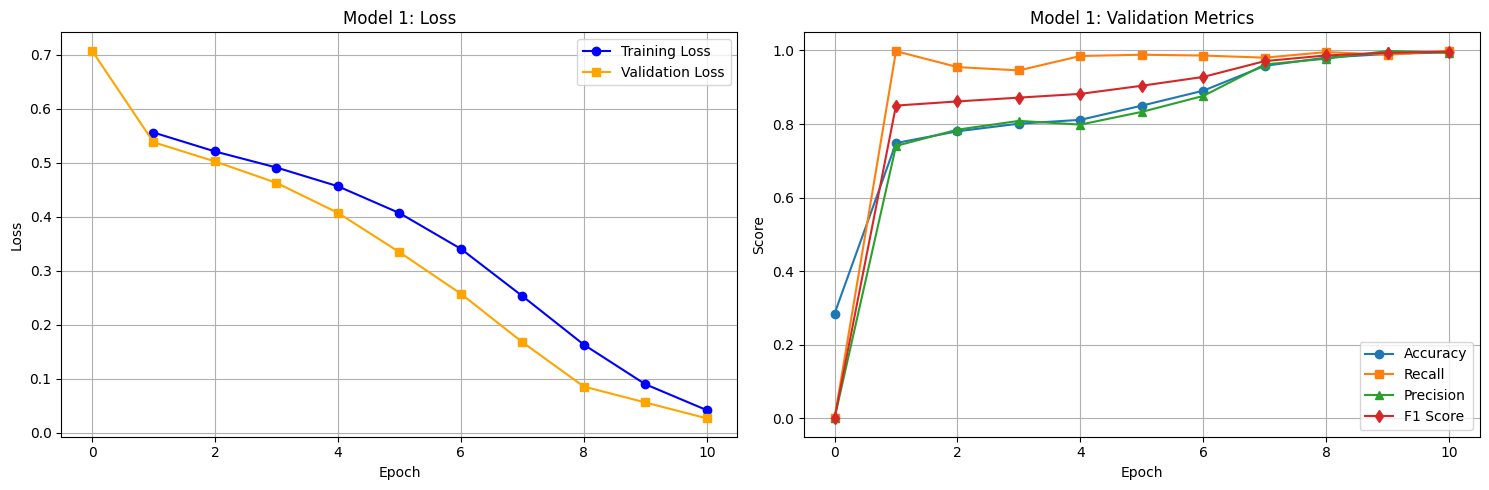

In [91]:
# Plot the training loss and metrics
plot_all_models([results])


In [99]:
save_dir = './models'
os.makedirs(save_dir, exist_ok=True)

In [100]:
torch.save(meta_model, os.path.join(save_dir, 'meta_model.pth'))
for i, base_model in enumerate(base_models):
    torch.save(base_model, os.path.join(save_dir, f'base_model_{i+1}.pth'))
    